## learning-AI101 : NVIDIA stock prediction (DL)
### 엔비디아 주식 데이터를 Dense layer struction과 1D-CNN, RNN, LSTM, GRU를 통한 prediction 수행

<br>

- **임규연 (lky473736)**
- 2024.08.17. ~ 2024.08.20.에 문서 작성
- **memo** : **stocker** (https://github.com/bobbruno/stocker/blob/master/readme.md) 라이브러리를 사용하여 엔비디아 주식 데이터를 RNN, LSTM, GRU, CNN로 prediction한다. 다만, stocker 라이브러리에서 data importing할 수 있는 최근 주식장 가격은 2018년 3월이다. 따라서 2018년 3월까지의 data를 이용한다.

-----------------

## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 NVIDIA의 다음 주식 가격을 regression한다. 목차는 아래와 같다.

- **1. 데이터 분석, 시각화 및 전처리**
- **2. 1D-CNN (time-series) using split_sequence**
- **3. RNN**
- **4. LSTM**
- **5. GRU**


In [1]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

2024-08-20 09:27:15.711710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


------

### 1. 데이터 분석, 시각화 및 전처리
- 데이터 로드 및 필요한 정보, 기초통계량을 get한다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.
- cell 순서는 아래와 같다.
    - (1) 데이터 읽기 및 head 파악
    - (2) 데이터 info (결측치 파악), 데이터 크기, 데이터 기초통계량 확인
    - (3) visualization stock price
    - (4) scaling (z-score normalization)
    - (5) train data, test data split

#### (1) 데이터 읽기 및 head 파악

In [2]:
# nvidia 주식 가져오기, head 출력

from tool.stocker import Stocker

nvidia = Stocker('NVDA').stock # Stocker 클래스의 stock attribute를 이용한 주식 dataframe 반환
nvidia.head()

Importing plotly failed. Interactive plots will not work.


NVDA Stocker Initialized. Data covers 1999-01-22 00:00:00 to 2018-03-27 00:00:00.


,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,ds,y,Daily Change
0,1999-01-22,21.00,23.44,18.63,19.69,5655600.0,0.0,1.0,1.623824,1.812497,1.440564,1.522529,67867200.0,1999-01-22,1.522529,-0.101296
1,1999-01-25,21.25,22.00,19.69,21.75,1063500.0,0.0,1.0,1.643156,1.701149,1.522529,1.681818,12762000.0,1999-01-25,1.681818,0.038662
2,1999-01-26,22.00,22.44,19.75,20.06,715000.0,0.0,1.0,1.701149,1.735172,1.527168,1.551139,8580000.0,1999-01-26,1.551139,-0.150010
3,1999-01-27,20.13,20.63,19.00,20.00,509100.0,0.0,1.0,1.556552,1.595214,1.469174,1.546499,6109200.0,1999-01-27,1.546499,-0.010052
4,1999-01-28,20.00,20.13,19.81,19.94,474000.0,0.0,1.0,1.546499,1.556552,1.531808,1.541860,5688000.0,1999-01-28,1.541860,-0.004639


**stocker** 라이브러리는 yahoo finance(https://finance.yahoo.com/) 에서 정보를 scrawling한다. 따라서 위 정보도 yahoo finance를 기준으로 dataframe이 구축된 것 같다. 위 feature에 대한 설명은 아래와 같다.

- **Date**: 해당 주식 데이터의 날짜.
- **Open**: 장이 시작할 때의 주식 가격.
- **High**: 해당 거래일 동안의 최고 주식 가격.
- **Low**: 해당 거래일 동안의 최저 주식 가격.
- **Close**: 거래일 종료 시의 주식 가격.
- **Volume**: 해당 거래일 동안 거래된 주식의 양.
- **Ex-Dividend**: 배당락 기준 가격 (배당에 대한 영향을 제거한 가격).
- **Split Ratio**: 주식 분할 비율.
- **Adj. Open**: 주식 분할이나 배당 등의 이벤트를 고려한 조정 후 개장 가격.
- **Adj. High**: 주식 분할이나 배당 등의 이벤트를 고려한 조정 후 최고 가격.
- **Adj. Low**: 주식 분할이나 배당 등의 이벤트를 고려한 조정 후 최저 가격.
- **Adj. Close**: 주식 분할이나 배당 등의 이벤트를 고려한 조정 후 종가.
- **Adj. Volume**: 주식 분할이나 배당 등의 이벤트를 고려한 조정 후 거래량.
- **ds**: Prophet 라이브러리에서 사용되는 날짜 정보 (Date와 동일).
- **y**: 예측하려는 타겟 변수로서의 주식 가격 (일반적으로 Adjusted Close 값과 동일).
- **Daily Change**: 일일 변동률을 나타내는 값으로, 종가와 개장가의 비율 차이

여기서 **ds를 주목**해보자. ds에 대한 설명에서 Prophet이 보인다. 본 stocker 라이브러리에서는 다양한 메소드를 제공하는데, 시계열에 따라서 본 주식의 추세를 보여주는 `obj.plot_stock()`가 그의 대한 예시이다. 재미있는 건, facebook에서 개발한 시계열 데이터 예측 모델인 **Prophet**를 이용하여 prediction 관련한 메소드까지 포함되어 있다는 것이다. 

<del>CNN, RNN, LSTM, GRU 이후에 번외로 본 라이브러리에서 제공하는 prediction method를 사용해 볼 예정이다.</del> <-- 할려고 했으나, prophet의 예전 버전인 **fbprophet**를 사용하고 있는 상황이라, 모든 fbprophet method를 prophet으로 변경해야 하기에 이는 추후 다른 tool를 사용하여 진행해보도록 한다.

- **feature**
  - Open: 개장 가격
  - High: 최고 가격
  - Low: 최저 가격
  - Close: 종가 (target variable)
  - Volume: 거래량

따라서 regression plan은 아래와 같다.

- **plan**
  - Open, High, Low, Close, Volume, Daily Change 열을 사용하여 예측 모델을 구축할 것이다.
  - Close를 target으로 설정한다.
  - Daily Change와 같은 추가적인 파생 변수를 포함하여 변동성을 반영할 수 있을지도 모른다.

In [3]:
# 실제값과 예측값 비교를 위해 따로 dataframe에서 떼어내어 저장

original_close = nvidia['Close'].values
dates = pd.to_datetime(nvidia['Date'])

In [4]:
# dataframe를 새로히 한다. (필요한 정보만)

cols = list(nvidia)[1:6]
nvidia = nvidia[cols].astype(float)
nvidia.head()

,Open,High,Low,Close,Volume
0,21.00,23.44,18.63,19.69,5655600.0
1,21.25,22.00,19.69,21.75,1063500.0
2,22.00,22.44,19.75,20.06,715000.0
3,20.13,20.63,19.00,20.00,509100.0
4,20.00,20.13,19.81,19.94,474000.0


#### (2) 데이터 info (결측치 파악), 데이터 크기, 데이터 기초통계량 확인

In [5]:
# 결측치 파악, 데이터 크기

print (nvidia.shape)
nvidia.info()

(4825, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4825 entries, 0 to 4824
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4825 non-null   float64
 1   High    4825 non-null   float64
 2   Low     4825 non-null   float64
 3   Close   4825 non-null   float64
 4   Volume  4825 non-null   float64
dtypes: float64(5)
memory usage: 188.6 KB


In [6]:
# 기초통계량 확인

nvidia.describe()

,Open,High,Low,Close,Volume
count,4825.000000,4825.000000,4825.000000,4825.000000,4.825000e+03
mean,36.968612,37.800557,36.112342,36.975141,1.073168e+07
std,41.166129,41.957559,40.329233,41.183512,8.721507e+06
min,6.000000,6.380000,5.750000,5.900000,4.100000e+04
25%,14.830000,15.030000,14.560000,14.810000,5.051700e+06
50%,21.560000,22.000000,21.070000,21.500000,8.821296e+06
75%,37.020000,37.670000,36.280000,37.000000,1.422530e+07
max,251.690000,254.500000,248.480000,250.480000,9.197937e+07


#### (3) visualization stock price
- 각 feature인 Open, High, Low, Close, Volume가 각 date의 변화에 따라 어떤 추세를 보이는지를 plot을 그려 확인한다.

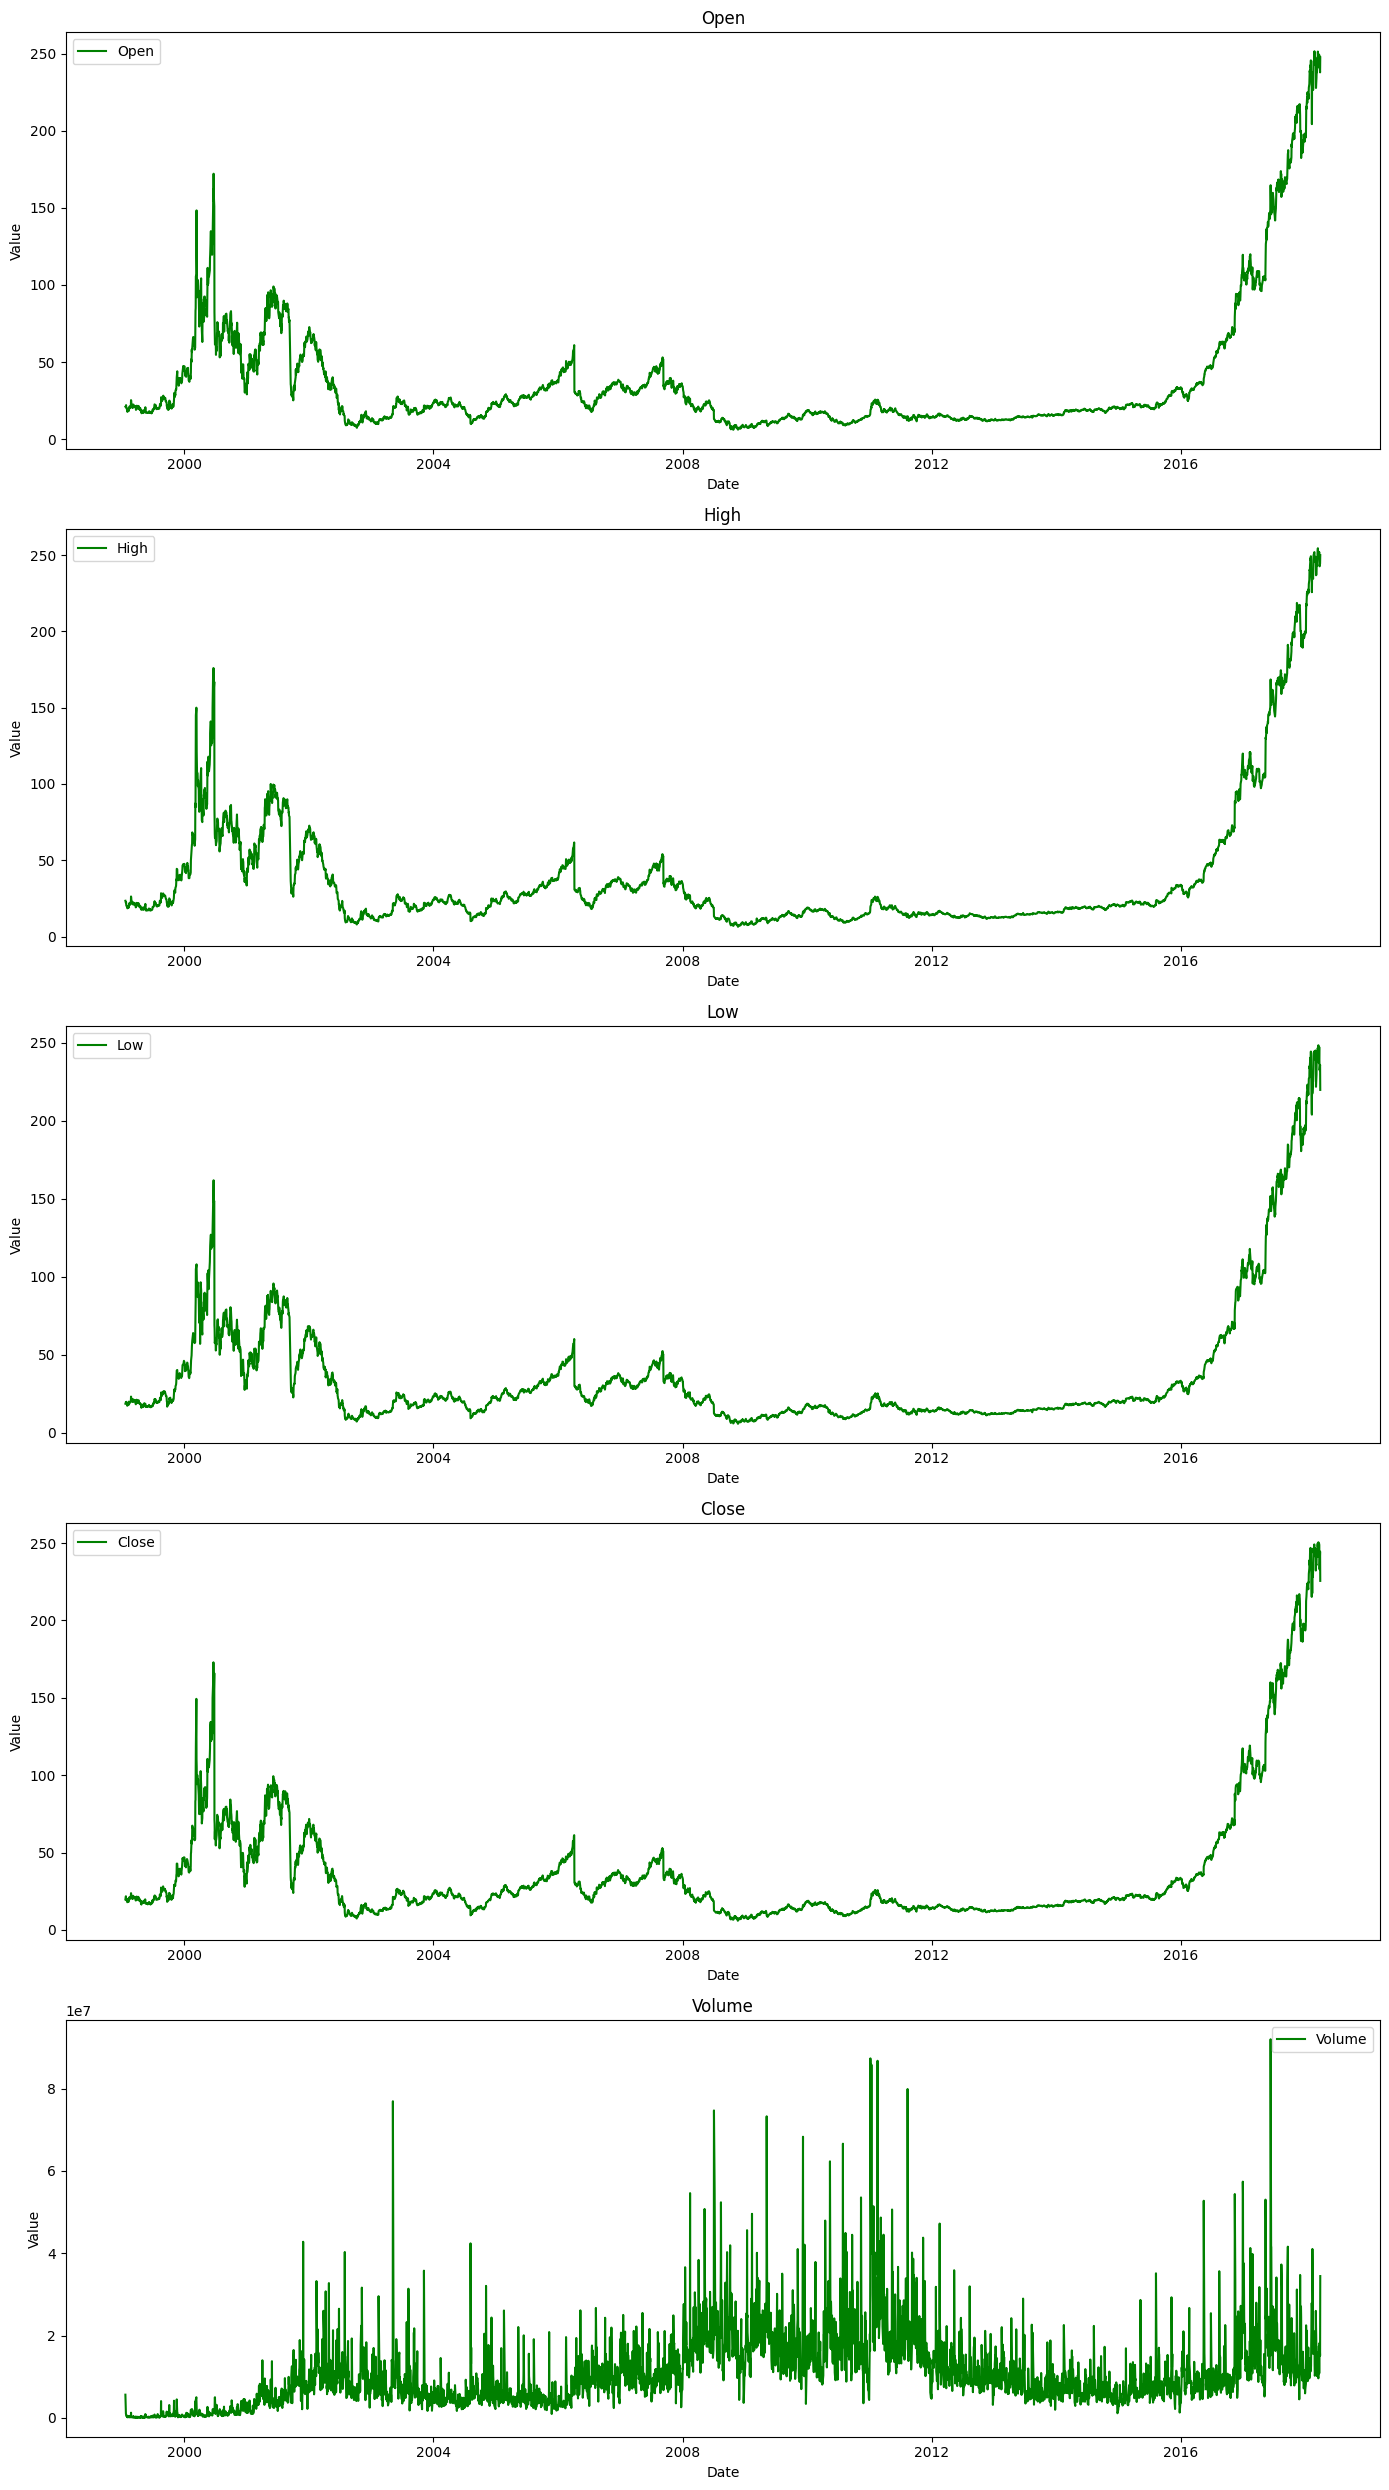

In [7]:
# visualization

columns = nvidia.columns

plt.figure(figsize=(14, 25))

# 5개의 subplot 생성
for i in range(0, 5) :
    plt.subplot(5, 1, i+1)  
    plt.plot(dates, nvidia[columns[i]], color='green', 
             label=f'{columns[i]}')
    plt.title(f'{columns[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()

# 그래프를 보여줌
plt.tight_layout()
plt.show()

**2016~2017년 이후로 완전한 우상향의 그래프를 그린다.** 아마도 AI의 급성장, 이세돌과 AlphaGo의 대국 및 GPU의 병렬 연산 학습으로 인한 여파가 아닐까 싶다. **진작에 엔비디아 주식을 살 껄 그랬다.**

#### (4) scaling (z-score normalization)

In [8]:
# normalize the dataset

scaler = StandardScaler()
scaler = scaler.fit(nvidia)
nvidia_scaled = scaler.transform(nvidia)

#### (5) train data, test data split
- **당연히 time-series data이기 때문에 기존과 같은 방식인 train_test_split을 사용하면 안된다.**
    - train_test_split은 기본적으로 data를 섞기 때문에 시간에 흐름에 따라 예측하는 본 모델에는 매우 부적합하다.
    - 따라서 slicing을 통하여 split을 진행한다.

In [9]:
# split to train data and test data
# train : test = 9 : 1

split_point = int(0.9 * nvidia.shape[0])
print ("split point : ", split_point)

train_nvidia = nvidia_scaled[:split_point]
train_dates = dates[:split_point]

test_nvidia = nvidia_scaled[split_point:]
test_dates = dates[split_point:]

train_nvidia.shape, test_nvidia.shape

split point :  4342


((4342, 5), (483, 5))

------

### 2. 1D-CNN (time-series) using split_sequence
- **reference : https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/**

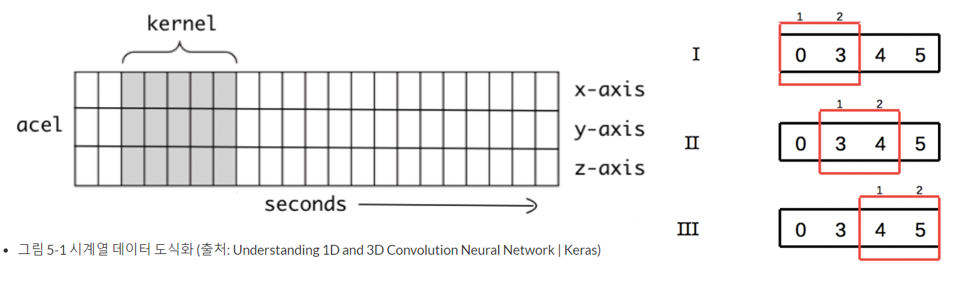

- 1D-CNN을 사용하여 다음 Close 값을 예측한다.
- 이때, split_sequence 함수를 이용하여 data를 step만큼 잘라 X set, y set을 만든다.
    - 다른 feature를 사용하지 않고 오직 **Close** 열을 사용하여 구성하기 때문에, 다소 부정확한 예측 모델이 만들어질 거라 예상한다.

In [10]:
# split a univariate sequence into samples 

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [11]:
# split data

n_steps = 30  # 30일의 step
X_train, y_train = split_sequence(train_nvidia[:, 3], n_steps)
X_test, y_test = split_sequence(test_nvidia[:, 3], n_steps)

In [12]:
# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 1 # feature 갯수

# 데이터 reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print (X_train.shape, X_test.shape)
print (X_train[0], y_train[0])

(4312, 30, 1) (453, 30, 1)
[[-0.41975372]
 [-0.36972852]
 [-0.41076861]
 [-0.41222566]
 [-0.4136827 ]
 [-0.43650974]
 [-0.42728179]
 [-0.46370791]
 [-0.4547228 ]
 [-0.43043872]
 [-0.41683963]
 [-0.43335281]
 [-0.45156587]
 [-0.45617984]
 [-0.41829668]
 [-0.39085567]
 [-0.38794158]
 [-0.41513975]
 [-0.40761168]
 [-0.39085567]
 [-0.38794158]
 [-0.3636575 ]
 [-0.32116037]
 [-0.33937342]
 [-0.36511455]
 [-0.36220046]
 [-0.36657159]
 [-0.40299771]
 [-0.4136827 ]
 [-0.38648454]] -0.3787136311223022


위 과정은 아래와 같은 순서로 진행되었다.
- (1) 상단 figure에서도 나와있듯이, split_sequence의 역할은 **step 만큼 X를 만들고, 그 다음 component를 y로 할당한다.** (단 이때, n_steps의 갯수는 kernel_size보다 커야 한다. 당연하지만, kernel이 일종의 도장이라면, 종이가 도장보다 작아서 되겠는가?)
- (2) 그 이후, reshape하여 1차원 CNN에 대입할 수 있는 형태로 만들어준 것이다.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 30, 128)           384       
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 64)            16448     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 64)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 448)               0     

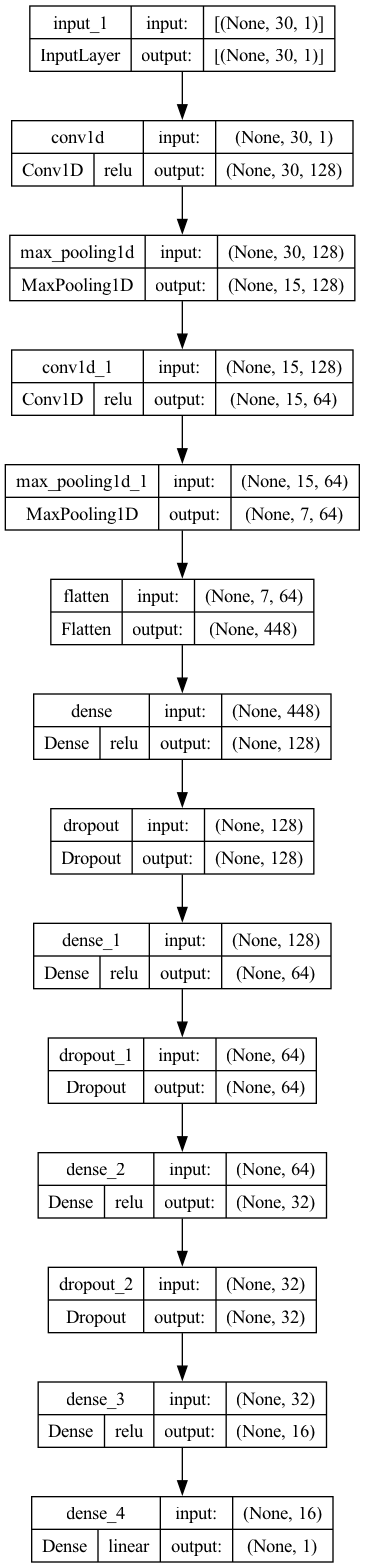

In [13]:
# modeling

from tensorflow.keras.models import Model

input_layer = keras.Input(shape=(n_steps, n_features))
x = keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', padding='same')(input_layer)
x = keras.layers.MaxPooling1D(pool_size=2)(x)
x = keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding='same')(x)
x = keras.layers.MaxPooling1D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(16, activation='relu')(x)
output_layer = keras.layers.Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=1, show_layer_activations=1)

In [14]:
# compile

model.compile(optimizer='adam', loss='mse')

In [15]:
# fit

history = model.fit(X_train, y_train, epochs=500, verbose=0)
print (history.history)

{'loss': [0.08867672085762024, 0.04144167900085449, 0.030732212588191032, 0.02927957847714424, 0.024081852287054062, 0.021613366901874542, 0.019476965069770813, 0.016524197533726692, 0.015057328157126904, 0.015245203860104084, 0.01391989178955555, 0.014051441103219986, 0.015315716154873371, 0.013072959147393703, 0.012810911051928997, 0.014393308199942112, 0.011701867915689945, 0.009495322592556477, 0.010606379248201847, 0.011706884950399399, 0.010984133929014206, 0.011117715388536453, 0.01151165273040533, 0.010525168851017952, 0.0105593241751194, 0.008495915681123734, 0.00909046083688736, 0.010087491944432259, 0.009781012311577797, 0.008791385218501091, 0.010047686286270618, 0.010508671402931213, 0.009639368392527103, 0.00898315105587244, 0.008839188143610954, 0.008231610991060734, 0.01098815817385912, 0.008302586153149605, 0.011050754226744175, 0.007697305176407099, 0.009907801635563374, 0.010135838761925697, 0.008308341726660728, 0.008303023874759674, 0.00781396683305502, 0.007710590

15/15 [==============================] - 0s 3ms/step


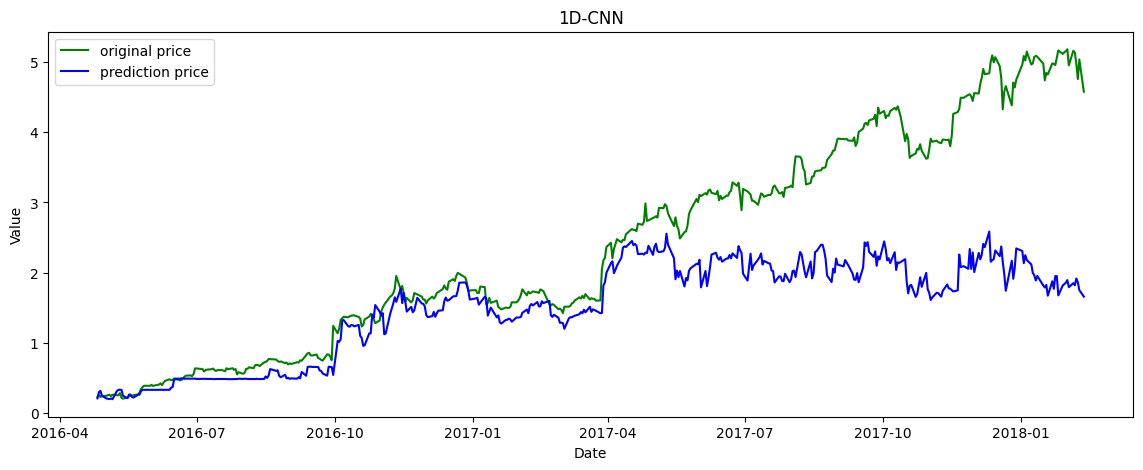

In [16]:
# model prediction이 잘 되는지 테스트 : visualization

y_pred = model.predict(X_test)

plt.figure(figsize=(14, 5))
plt.plot(test_dates[:y_test.shape[0]], y_test, color='green', 
         label='original price')
plt.plot(test_dates[:y_test.shape[0]], y_pred, color='blue', 
         label='prediction price')
plt.title(f'1D-CNN')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

위 graph를 보고 **지금보다 더 일찍이라도 AI를 공부했더라면 더욱 성능 좋은 prediction machine을 만들었을 수 있었겠다고 생각했다.** 그에 대한 이유는 명확한데,

- 매우 간단히, 하나의 target attribute를 time-series 방식으로 split하여 CNN하기만 했어도 original price의 추이와 prediction price의 추이가 굉장히 비슷하다는 것이다.
- 또한, 2017년 4월 전까지의 price를 볼 때, 둘은 거의 차이가 없다. 또한 가격 변동도 차이가 거의 없이 둘이 비슷한 시기에 상승 / 하강하는 것을 확인할 수 있다.
- 하지만, **2017년 4월 이후로부터 실제 price는 상승하지만, 예측 price는 제자리를 유지한 채, 상승과 하강만 동일한 양상을 보이고 있다.**
- 만약에 이 모델에서 아래와 같은 정보를 추가한다면, 실시간적으로 주식의 가격을 예측하는 real-time predictor를 만들 수 있지 않을까?
    - 실시간 뉴스 반영
        - 해당 주식에 대한 저널 및 뉴스를 실시간으로 웹 스크래핑하여 여론을 파악한 후 이를 통해 언제 주식을 얼만큼 살지, 말지를 파악할 수도 있겠다.
        - 잘하면 비슷한 계열 주들의 가격까지 예측 가능하게끔 modeling할 수도 있을 것이다. (보통 특정 회사의 여론은 다른 비슷한 계열의 회사까지 영향을 미치니)
    - 해외 시세 반영

------

### 3. RNN
- RNN을 사용하여 modeling한다.
- activation은 tanh를 사용한다. tanh를 사용하기 때문에 이전에 StandScaler를 통해 scaling한 것이다.
- RNN 이후에 Dense layer을 통한 regression formation을 만든다.

train set, test set을 아래와 같이 구성한다.

- 10일을 window_size로 두고, 그 10일을 이용하여 다음 날의 close값을 예측하는 형식으로 data를 split
- 일단은 리스트를 이용하여 data set을 구축 후에 ndarray로 변환하자.

In [17]:
# train, test data의 길이와 window_size 정의

print (len(train_nvidia), len(test_nvidia))
window_size = 10

4342 483


In [22]:
# train, test data split

X_train, y_train, X_test, y_test = list(), list(), list(), list()

current_ind = 0

# X_train, y_train
while True : 
    if current_ind + window_size >= len(train_nvidia) : 
        print ("Train dataset index out")
        break
        
    else : 
        # X_train에 window_size만큼의 데이터를 추가
        X_train.append(train_nvidia[current_ind:current_ind + window_size])
        # y_train에 해당하는 다음 데이터를 추가
        y_train.append(train_nvidia[current_ind + window_size][3]) # 3번째 index == Close
        current_ind += 1  # 다음 위치로 이동

        
# X_test, y_test
current_ind = 0  # initialization

while True: 
    if current_ind + window_size >= len(test_nvidia) : 
        print ("Test dataset index out")
        break
        
    else : 
        # X_test에 window_size만큼의 데이터를 추가
        X_test.append(test_nvidia[current_ind:current_ind + window_size])
        # y_test에 해당하는 다음 데이터를 추가
        y_test.append(test_nvidia[current_ind + window_size][3]) # 3번째 index == Close
        current_ind += 1  # 다음 위치로 이동

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Train dataset index out
Test dataset index out
(4332, 10, 5) (4332,)
(473, 10, 5) (473,)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 256)               67072     
                                                                 
 dense_18 (Dense)            (None, 64)                16448     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_2 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                      

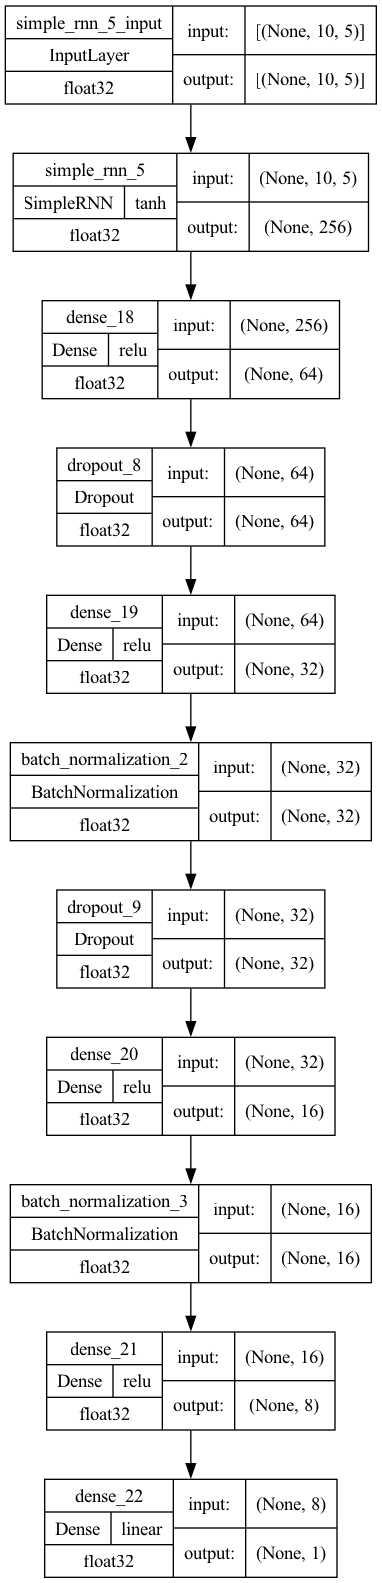

In [33]:
# modelling

model = keras.Sequential([
    keras.layers.SimpleRNN(256, input_shape=(10, 5)), 
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1)
])

model.summary()
keras.utils.plot_model(model, show_dtype=True, 
                      show_layer_activations=True,
                      show_shapes=True)

In [34]:
# compile

model.compile(optimizer='adam', loss='mse')

In [35]:
# fit

history = model.fit(X_train, y_train, epochs=500, verbose=0)
print (history.history)

{'loss': [0.2616194784641266, 0.0858401358127594, 0.05964154750108719, 0.050417929887771606, 0.04034850001335144, 0.034999433904886246, 0.029850341379642487, 0.027156157419085503, 0.024468576535582542, 0.021686047315597534, 0.022151583805680275, 0.020905768498778343, 0.020429063588380814, 0.016520245000720024, 0.01617296226322651, 0.017334118485450745, 0.015770958736538887, 0.016413459554314613, 0.013400893658399582, 0.017967164516448975, 0.015205085277557373, 0.01483782660216093, 0.012751264497637749, 0.015055558644235134, 0.013184307143092155, 0.011535129509866238, 0.01147383451461792, 0.015209818258881569, 0.011061575263738632, 0.011557845398783684, 0.012427627108991146, 0.011858314275741577, 0.010191849432885647, 0.01025298610329628, 0.011428643018007278, 0.01046872977167368, 0.00954502634704113, 0.010240987874567509, 0.01169025432318449, 0.010025398805737495, 0.010764950886368752, 0.009353469125926495, 0.008512858301401138, 0.00923580676317215, 0.008344228379428387, 0.010750047862

15/15 [==============================] - 0s 4ms/step


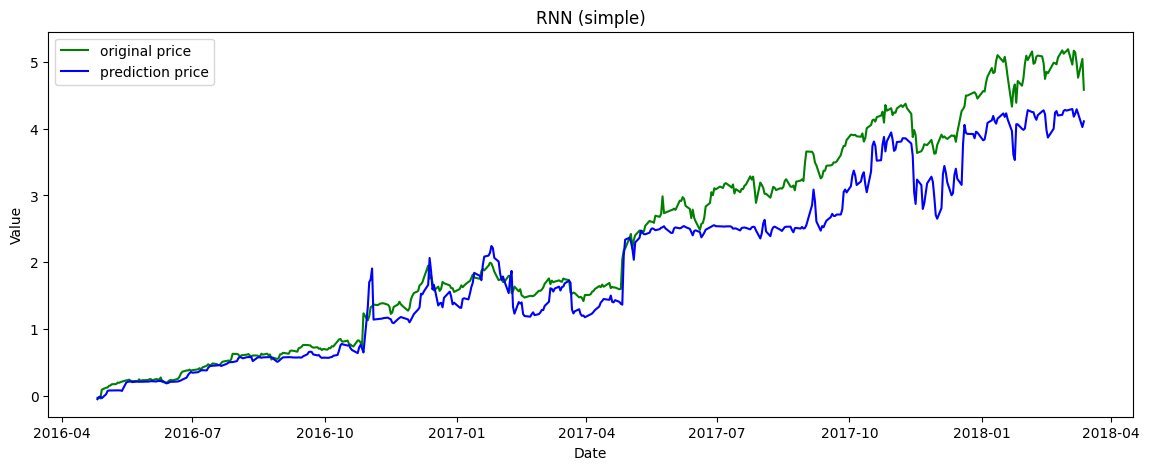

In [36]:
# model prediction이 잘 되는지 테스트 : visualization

y_pred = model.predict(X_test)

plt.figure(figsize=(14, 5))
plt.plot(test_dates[:y_test.shape[0]], y_test, color='green', 
         label='original price')
plt.plot(test_dates[:y_test.shape[0]], y_pred, color='blue', 
         label='prediction price')
plt.title(f'RNN (simple)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

이전 1D-CNN의 시각화 figure와 비교하였을 때, 이번에는 prediction line의 폭 또한 기존 original line을 따라서 큰 차이 없이 예측하고 있는 것을 확인 가능하다. 다만, prediction line이 original line보다 높게 측정되는 point가 일부 존재하기는 한다. 일종의 spark처럼 price가 뛰는 현상이 발생한 것이다. 이에 대한 원인을 예측해보자면 아래와 같다.

- 현재 하이퍼파라미터나 model layer structure가 가격의 변동폭을 제대로 잡지 못하는 것일수도 있다는 생각이 든다.
    - 1D-CNN에 비해서는 차이를 줄였고, original과 비교하였을 때, minima, maxima 등의 극점 또한 동일하지만 오르고 내리는 폭이 차이가 있기 때문
- LSTM이나 GRU에서 더 개선될 수 있을 것인가가 궁금

------

### 4. LSTM

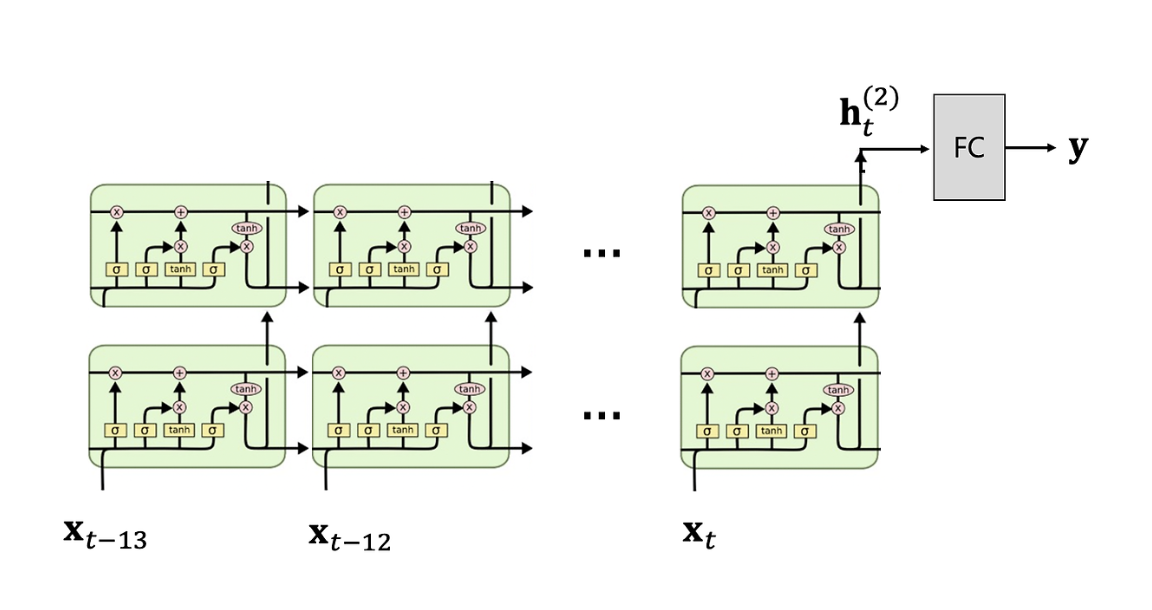
- LSTM을 사용하여 modeling한다. LSTM layer를 여러 개 겹쳐서 구성한다.
    - 위 figure와 같이 **stack LSTM**을 통해 prediction할 것이다.
        - 1층에서 모든 sequence의 hidden state를 출력해야 하기 때문에, hyperparameter를 return_sequences=True로 두어야 할 것이다.
        - 2층에서 마지막 sequence의 출력이 필요하기 때문에 False로 둔다.
- LSTM 이후에 Dense layer을 통한 regression formation을 만든다.

train set, test set은 이전에 사용한 X_train, y_train, X_test, y_test를 재활용한다.

아래와 같이 experiment한다.

- (1) stack LSTM
- (2) 단일 LSTM

#### (4-1) stack LSTM

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 64)            17920     
                                                                 
 lstm_19 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 128)               8320      
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_55 (Dense)            (None, 64)                8256      
                                                                 
 dropout_28 (Dropout)        (None, 64)              

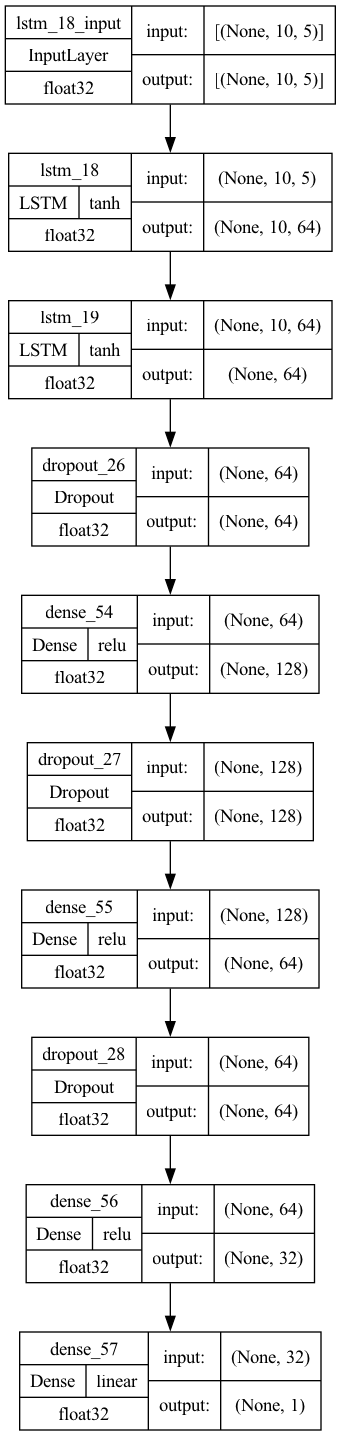

In [77]:
# modelling

model = keras.Sequential([
    keras.layers.LSTM(64, input_shape=(10, 5),
                      return_sequences=True),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.summary()
keras.utils.plot_model(model, show_dtype=True, 
                      show_layer_activations=True,
                      show_shapes=True)

In [78]:
# compile

model.compile(optimizer='adam', loss='mse')

In [79]:
# fit

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=10)

history = model.fit(X_train, y_train, epochs=500, callbacks=[es], verbose=True)
print (history.history)

Epoch 1/500
136/136 [==============================] - 5s 11ms/step - loss: 0.0486
Epoch 2/500
136/136 [==============================] - 1s 8ms/step - loss: 0.0239
Epoch 3/500
136/136 [==============================] - 1s 7ms/step - loss: 0.0198
Epoch 4/500
136/136 [==============================] - 1s 10ms/step - loss: 0.0150
Epoch 5/500
136/136 [==============================] - 1s 10ms/step - loss: 0.0156
Epoch 6/500
136/136 [==============================] - 2s 12ms/step - loss: 0.0167
Epoch 7/500
136/136 [==============================] - 1s 8ms/step - loss: 0.0142
Epoch 8/500
136/136 [==============================] - 1s 7ms/step - loss: 0.0117
Epoch 9/500
136/136 [==============================] - 1s 7ms/step - loss: 0.0096
Epoch 10/500
136/136 [==============================] - 1s 6ms/step - loss: 0.0092
Epoch 11/500
136/136 [==============================] - 1s 7ms/step - loss: 0.0114
Epoch 12/500
136/136 [==============================] - 1s 8ms/step - loss: 0.0111
Epoch 13/

15/15 [==============================] - 1s 2ms/step


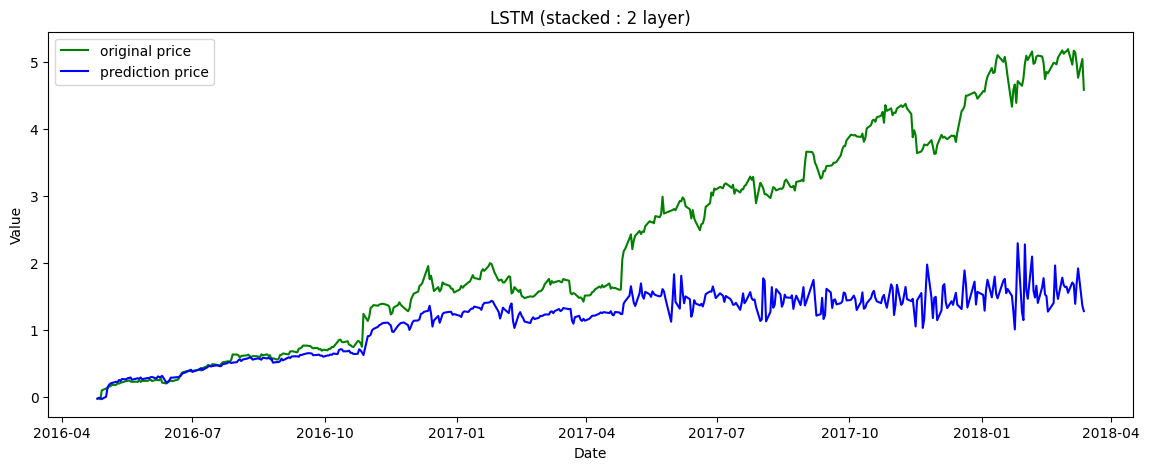

In [80]:
# model prediction이 잘 되는지 테스트 : visualization

y_pred = model.predict(X_test)

plt.figure(figsize=(14, 5))
plt.plot(test_dates[:y_test.shape[0]], y_test, color='green', 
         label='original price')
plt.plot(test_dates[:y_test.shape[0]], y_pred, color='blue', 
         label='prediction price')
plt.title(f'LSTM (stacked : 2 layer)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

#### (4-2) 단일 LSTM

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                17920     
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_58 (Dense)            (None, 128)               8320      
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_59 (Dense)            (None, 64)                8256      
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_60 (Dense)            (None, 32)              

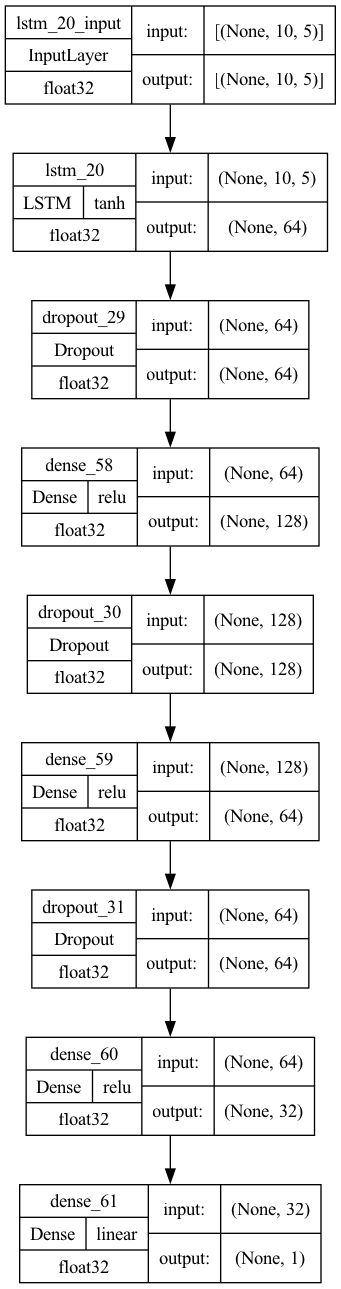

In [81]:
# modelling

model = keras.Sequential([
    keras.layers.LSTM(64, input_shape=(10, 5)),
    # keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.summary()
keras.utils.plot_model(model, show_dtype=True, 
                      show_layer_activations=True,
                      show_shapes=True)

In [82]:
# compile

model.compile(optimizer='adam', loss='mse')

In [83]:
# fit

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=10)

history = model.fit(X_train, y_train, epochs=500, callbacks=[es], verbose=True)
print (history.history)

Epoch 1/500
136/136 [==============================] - 2s 3ms/step - loss: 0.0416
Epoch 2/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 3/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 4/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 5/500
136/136 [==============================] - 1s 4ms/step - loss: 0.0131
Epoch 6/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 7/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 8/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 9/500
136/136 [==============================] - 1s 4ms/step - loss: 0.0111
Epoch 10/500
136/136 [==============================] - 1s 4ms/step - loss: 0.0094
Epoch 11/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 12/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 13/500


15/15 [==============================] - 0s 2ms/step


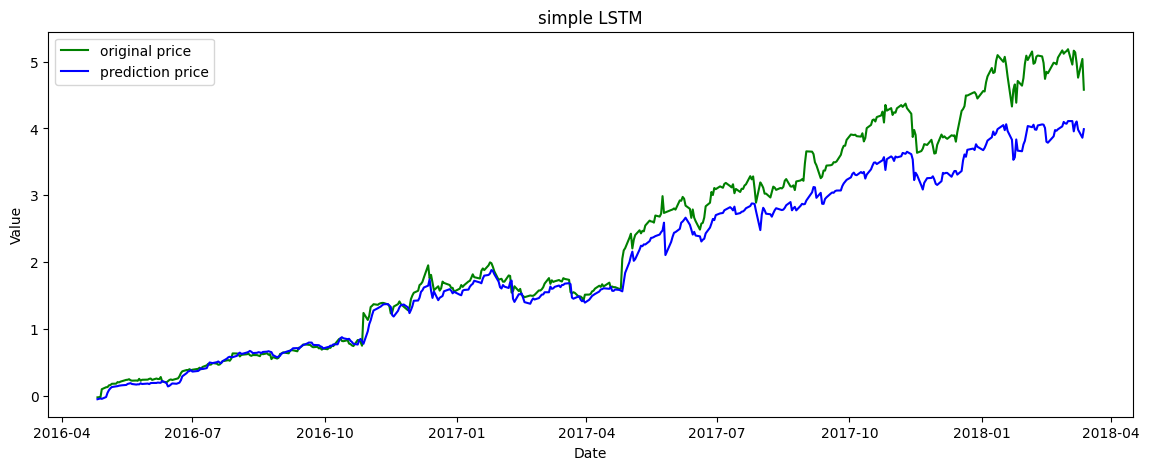

In [84]:
# model prediction이 잘 되는지 테스트 : visualization

y_pred = model.predict(X_test)

plt.figure(figsize=(14, 5))
plt.plot(test_dates[:y_test.shape[0]], y_test, color='green', 
         label='original price')
plt.plot(test_dates[:y_test.shape[0]], y_pred, color='blue', 
         label='prediction price')
plt.title(f'simple LSTM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

**simple LSTM이 stack LSTM보다 더욱 효과적으로 prediction하고 있는 것을 확인 가능하다.**

------

### 5. GRU

- LSTM과 원리가 비슷하면서, 계산양이 적은 GRU를 사용하여 modeling한다.
- simple GRU, 즉 stack하여 layer를 구성하지 않으며, 이전 simple LSTM과 추이를 비교할 예정이다.

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                13632     
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 dense_62 (Dense)            (None, 128)               8320      
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_63 (Dense)            (None, 64)                8256      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_64 (Dense)            (None, 32)              

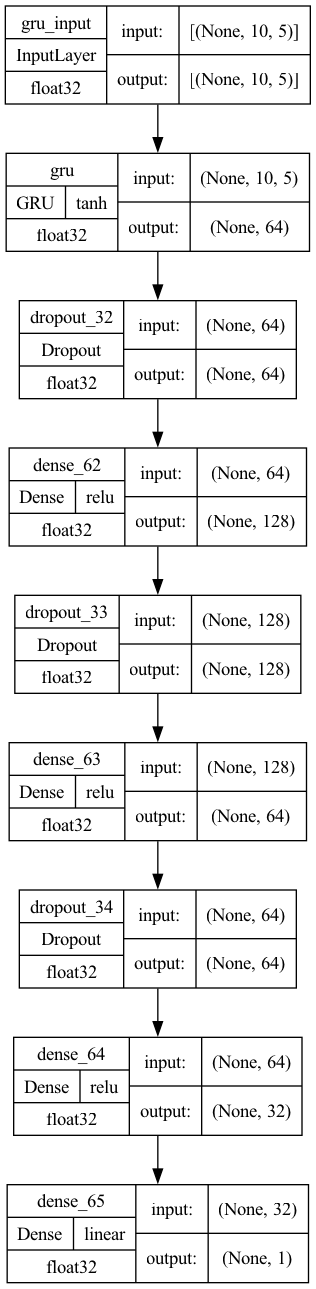

In [85]:
# modelling

model = keras.Sequential([
    keras.layers.GRU(64, input_shape=(10, 5)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.summary()
keras.utils.plot_model(model, show_dtype=True, 
                      show_layer_activations=True,
                      show_shapes=True)

In [86]:
# compile

model.compile(optimizer='adam', loss='mse')

In [87]:
# fit

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=10)

history = model.fit(X_train, y_train, epochs=500, callbacks=[es], verbose=True)
print (history.history)

Epoch 1/500
136/136 [==============================] - 2s 3ms/step - loss: 0.0395
Epoch 2/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0214
Epoch 3/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 4/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5/500
136/136 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 6/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7/500
136/136 [==============================] - 0s 4ms/step - loss: 0.0100
Epoch 8/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 9/500
136/136 [==============================] - 1s 4ms/step - loss: 0.0091
Epoch 10/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 11/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 12/500
136/136 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 13/500


15/15 [==============================] - 0s 2ms/step


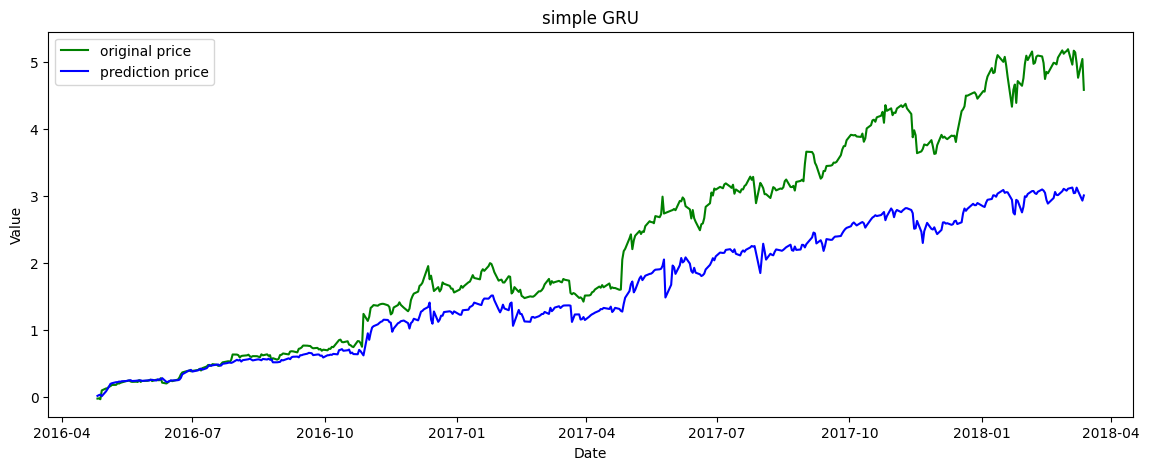

In [88]:
# model prediction이 잘 되는지 테스트 : visualization

y_pred = model.predict(X_test)

plt.figure(figsize=(14, 5))
plt.plot(test_dates[:y_test.shape[0]], y_test, color='green', 
         label='original price')
plt.plot(test_dates[:y_test.shape[0]], y_pred, color='blue', 
         label='prediction price')
plt.title(f'simple GRU')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

**simple GRU보다는 simple LSTM이 차이폭을 개선하면서도 극점을 반영하면서 예측하고 있음을 확인 가능하다.**